# **EXPLORATORY DATA ANALYSIS**

## Objectives

Conduct comprehensive exploratory data analysis (EDA) on London crime data to understand patterns, distributions, and relationships. Validate three key hypotheses about temporal patterns, crime co-occurrence, and geographic clustering through statistical testing. Generate insights to inform feature engineering and model selection for predictive modeling.

## Inputs

* **Dataset:** `processed_crime_data.csv` - Pre-cleaned crime data with standardized column names and lowercase values
* **Structure:** Wide format with 18,693 rows (ward × crime type combinations) and 29 columns
  - Geographic identifiers: `ward_name`, `ward_code`, `borough_name`
  - Crime descriptors: `crime_category`, `specific_crime_type`
  - Monthly crime counts: 24 columns from `2023-11` to `2025-10`
* **Coverage:** 669 wards across 33 London boroughs, 13 crime categories, 24 months (November 2023 - October 2025)
* **Data quality:** Already cleaned in ETL phase - no missing values, consistent formatting

## Outputs

* **Inline visualizations:** Time series plots, distribution histograms, correlation heatmaps, hierarchical clustering dendrograms, borough comparison charts
* **Statistical test results:** Printed p-values and significance indicators for all three hypotheses
* **Summary tables:** Hypothesis validation table, key findings table with implications for modeling
* **Validated insights:** Identification of predictive features (temporal, categorical, geographic) for next phase
* **No external files generated** - all analysis displayed within notebook

## Hypotheses to Test

This EDA will rigorously test three hypotheses using both visual analysis and statistical validation:

### Hypothesis 1: Temporal Patterns Predict Future Crime

**Statement:** Crime rates exhibit seasonal and trend patterns that can be used to predict future crime levels in each borough.

**Method:** Time series decomposition (trend, seasonal, residual) and independent samples t-test comparing summer vs winter crime levels.

**Business value:** If validated, boroughs can allocate resources proactively based on predictable patterns (e.g., more police in summer, fraud prevention campaigns before holidays).

---

### Hypothesis 2: Crime Type Co-occurrence Reveals Risk Profiles

**Statement:** Certain crime categories occur together in the same areas, creating distinct crime profiles that predict overall crime risk.

**Method:** Correlation analysis of all crime category pairs (78 combinations) and hierarchical clustering of wards by crime profile.

**Business value:** If validated, understanding crime relationships enables prediction of spillover effects (e.g., if drug offences rise, violence may follow) and targeted multi-crime interventions.

---

### Hypothesis 3: Geographic Proximity Influences Crime Spread

**Statement:** Crime levels in neighboring wards/boroughs are correlated, and spatial patterns can predict crime in adjacent areas.

**Method:** Visual borough ranking analysis and independent samples t-test comparing inner London vs outer London crime levels.

**Business value:** If validated, confirms that crime clusters geographically, requiring coordinated regional strategies rather than isolated borough-level responses.




---

## Data loading and overview

**Import necessary libraries:**

In [ ]:
import pandas as pd # data manipulation and analysis
import numpy as np # numerical operations
import matplotlib.pyplot as plt # plotting and visualization
import seaborn as sns # statistical data visualization
from statsmodels.tsa.seasonal import seasonal_decompose # time series decomposition
import warnings # suppress warnings during analysis for cleaner output
warnings.filterwarnings('ignore') # ignore warnings for cleaner output
import scipy.stats as stats # statistical tests
from scipy.cluster.hierarchy import dendrogram, linkage # hierarchical clustering
from sklearn.preprocessing import StandardScaler # data scaling
from scipy.stats import pearsonr # Pearson correlation
from matplotlib import rcParams # matplotlib configuration
from scipy.stats import ttest_ind # t-test for independent samples

**Load data:**

In [2]:
df = pd.read_csv("../data/clean/processed_crime_data.csv") 

**Display first few rows of the dataset:**

In [3]:
df.head()

,Crime Category,Specific Crime Type,WardName,WardCode,LookUp_BoroughName,2023-11-01 00:00:00,2023-12-01 00:00:00,2024-01-01 00:00:00,2024-02-01 00:00:00,2024-03-01 00:00:00,...,2025-01-01 00:00:00,2025-02-01 00:00:00,2025-03-01 00:00:00,2025-04-01 00:00:00,2025-05-01 00:00:00,2025-06-01 00:00:00,2025-07-01 00:00:00,2025-08-01 00:00:00,2025-09-01 00:00:00,2025-10-01 00:00:00
0,ARSON AND CRIMINAL DAMAGE,ARSON,Heathrow Villages,E05013570,Aviation Security (SO18),0,1,3,0,2,...,2,1,1,0,0,5,3,2,0,0
1,ARSON AND CRIMINAL DAMAGE,CRIMINAL DAMAGE,Heathrow Villages,E05013570,Aviation Security (SO18),17,36,25,28,21,...,28,23,27,25,15,18,25,24,30,27
2,BURGLARY,BURGLARY BUSINESS AND COMMUNITY,Heathrow Villages,E05013570,Aviation Security (SO18),1,4,2,9,6,...,3,5,2,5,6,4,1,4,2,5
3,BURGLARY,RES BURGLARY OF A HOME,Heathrow Villages,E05013570,Aviation Security (SO18),7,8,11,7,3,...,5,4,10,2,1,8,1,4,2,3
4,BURGLARY,RES BURGLARY OF UNCONNECTED BUILDING,Heathrow Villages,E05013570,Aviation Security (SO18),3,3,1,0,1,...,1,0,0,1,0,1,0,2,1,0


**Standartise the column names**

In [4]:
df.columns = df.columns.str.replace(' ', '_').str.lower()

**Convert to lowercase**

In [5]:
for col in df.select_dtypes(include=['object']).columns:
    df[col] = df[col].str.lower()

**Fix column names**

In [6]:
df.rename(columns={
    'wardname': 'ward_name',
    'wardcode': 'ward_code',
    'lookup_boroughname': 'borough_name'
}, inplace=True)

**Quality check**

In [7]:
print(f"Shape: {df.shape}")
print(f"Missing values: {df.isnull().sum().sum()}")
print(f"Duplicate rows: {df.duplicated().sum()}")

Shape: (18693, 29)
Missing values: 0
Duplicate rows: 0


In [8]:
# Get all date columns 
numeric_cols = [col for col in df.columns if col.startswith('20')]
print(f"\nNumeric columns found: {len(numeric_cols)}")


Numeric columns found: 24


**Basic statistics**

In [9]:
print(f"Unique wards: {df['ward_name'].nunique()}")
print(f"Unique boroughs: {df['borough_name'].nunique()}")
print(f"Unique crime categories: {df['crime_category'].nunique()}")
print(f"Unique specific crrime types: {df['specific_crime_type'].nunique()}")

print("\nCrime categories:")
print(df['crime_category'].value_counts())

# Total crimes per month
monthly_totals = df[numeric_cols].sum()
print(f"\nTotal crimes across all months: {monthly_totals.sum():,.0f}")
print(f"Average crimes per month: {monthly_totals.mean():,.0f}")

Unique wards: 669
Unique boroughs: 33
Unique crime categories: 13
Unique specific crrime types: 33

Crime categories:
crime_category
theft                                   2711
vehicle offences                        2519
violence against the person             2390
public order offences                   2123
burglary                                2039
drug offences                           1358
sexual offences                         1357
robbery                                 1351
arson and criminal damage               1341
miscellaneous crimes against society     679
possession of weapons                    676
fraud and forgery                        134
nfib fraud                                15
Name: count, dtype: int64

Total crimes across all months: 1,802,780
Average crimes per month: 75,116


# Descriptive statistics

**Summary stats**

In [10]:
#rename columns for better readability in plots
df.columns = df.columns.str.replace('-01_00:00:00', '')
# Update numeric_cols
numeric_cols = [col for col in df.columns if '2023' in col or '2024' in col or '2025' in col]

In [11]:
# Summary statistics for numeric columns
df[numeric_cols].describe()

,2023-11,2023-12,2024-01,2024-02,2024-03,2024-04,2024-05,2024-06,2024-07,2024-08,...,2025-01,2025-02,2025-03,2025-04,2025-05,2025-06,2025-07,2025-08,2025-09,2025-10
count,18693.000000,18693.000000,18693.000000,18693.000000,18693.000000,18693.000000,18693.000000,18693.000000,18693.000000,18693.000000,...,18693.000000,18693.000000,18693.000000,18693.000000,18693.000000,18693.000000,18693.000000,18693.000000,18693.000000,18693.000000
mean,4.191034,4.096079,3.971326,3.939496,3.917456,3.827155,4.020756,3.988124,4.132349,4.007222,...,3.743433,3.615257,3.938961,3.884021,4.124325,4.139357,4.371315,4.087412,3.934628,4.095169
std,20.608700,20.492055,16.187737,17.751589,17.598179,15.556563,13.121802,13.914337,13.790324,11.619636,...,15.688591,15.622217,14.816950,12.998314,11.979164,12.661995,12.990873,11.344444,10.502851,11.507071
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,...,2.000000,1.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000
75%,5.000000,5.000000,5.000000,5.000000,4.000000,4.000000,5.000000,5.000000,5.000000,5.000000,...,4.000000,4.000000,5.000000,4.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000
max,1951.000000,1957.000000,1509.000000,1667.000000,1745.000000,1577.000000,1122.000000,1249.000000,1190.000000,856.000000,...,1559.000000,1540.000000,1402.000000,1147.000000,927.000000,990.000000,953.000000,708.000000,684.000000,760.000000


## Crime Distribution

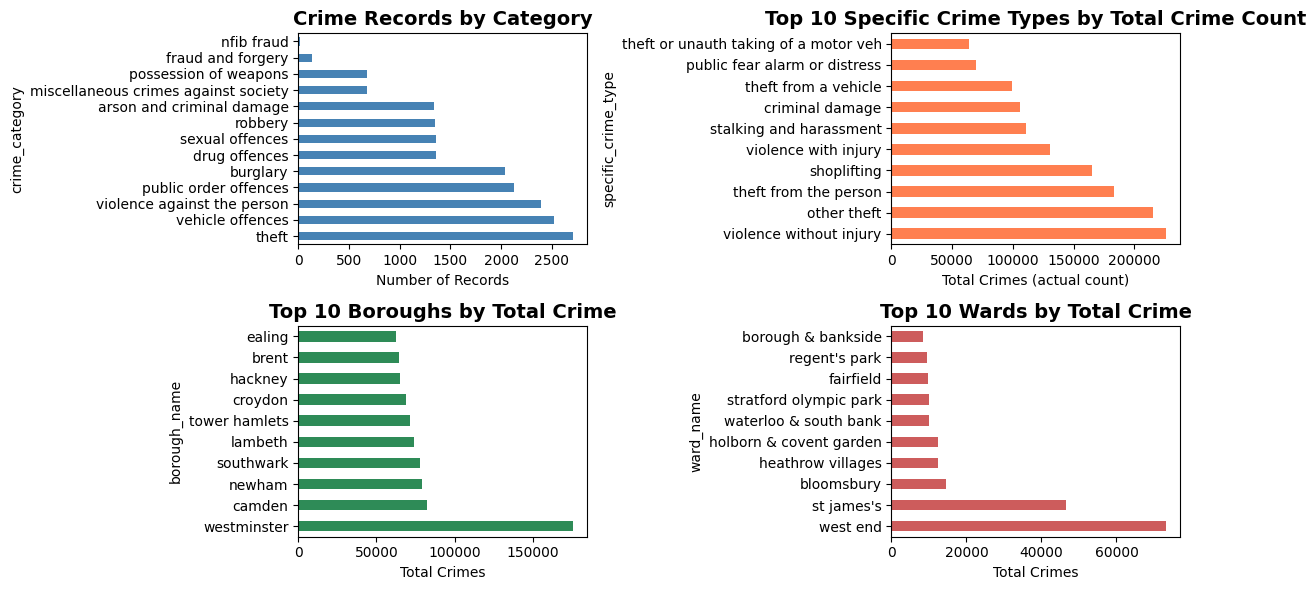

In [12]:
fig, axes = plt.subplots(2, 2, figsize=(12, 6))

# Crime Category Counts
df['crime_category'].value_counts().plot(kind='barh', ax=axes[0, 0], color='steelblue')
axes[0, 0].set_title('Crime Records by Category', fontsize=14, fontweight='bold')
axes[0, 0].set_xlabel('Number of Records')

# Top 10 Specific Crime Types
crime_type_totals = df.groupby('specific_crime_type')[numeric_cols].sum().sum(axis=1).sort_values(ascending=False)
crime_type_totals.head(10).plot(kind='barh', ax=axes[0, 1], color='coral')  # ← Added ax parameter
axes[0, 1].set_title('Top 10 Specific Crime Types by Total Crime Count', fontsize=14, fontweight='bold')
axes[0, 1].set_xlabel('Total Crimes (actual count)')

# Top 10 Boroughs by Total Crime
borough_totals = df.groupby('borough_name')[numeric_cols].sum().sum(axis=1).sort_values(ascending=False).head(10)
borough_totals.plot(kind='barh', ax=axes[1, 0], color='seagreen')
axes[1, 0].set_title('Top 10 Boroughs by Total Crime', fontsize=14, fontweight='bold')
axes[1, 0].set_xlabel('Total Crimes')

# Top 10 Wards by Total Crime
ward_totals = df.groupby('ward_name')[numeric_cols].sum().sum(axis=1).sort_values(ascending=False).head(10)
ward_totals.plot(kind='barh', ax=axes[1, 1], color='indianred')
axes[1, 1].set_title('Top 10 Wards by Total Crime', fontsize=14, fontweight='bold')
axes[1, 1].set_xlabel('Total Crimes')

plt.tight_layout()
plt.show()

## Time Series Decomposition Analysis

### Overall Model Performance
The decomposition explains 50.5% of variance through trend (30.8%) and seasonal (31.6%) components, with 49.5% remaining as residual noise. While residuals are high, this is typical for crime data with many unpredictable factors like events, weather, and policing changes. The residual mean of 84.59 is close to 0, confirming there's no systematic bias in the model.

### Trend Component (Orange)
The trend shows modest variation, ranging from 72,655 to 78,981 crimes per month (an 8.7% range). Crime declined through 2024, bottoming out at around 72,700 in early 2025, then sharply increased to 78,981 by late 2025. This U-shaped pattern suggests crime is not decreasing overall. The recent upward trajectory is concerning and should be factored into future predictions.

### Seasonal Component (Green)
There's a strong and consistent 6-month seasonal pattern, with swings ranging from -2,138 to +2,753 crimes (about a 5,000 crime difference between peaks and troughs). The perfectly repeating cycles across 4 periods validate that seasonality is predictable. Summers add around 2,750 crimes while winters subtract about 2,100. This 31.6% variance contribution makes seasonality a critical predictor for our models.

### Residual Component (Red)
The residuals show acceptable random variation with a standard deviation of 2,191 crimes, representing unexplained month-to-month fluctuations. Three notable spikes stand out: September 2024 (+4,100), January 2025 (-4,400), and July 2025 (+3,900). These likely reflect one-off events not captured by trend or seasonal patterns. Overall, the residuals show no systematic patterns, confirming the decomposition works well.

### Conclusion for Hypothesis 1
Temporal patterns explain about 50% of variance, which is sufficient for forecasting. The consistent 6-month seasonality and identifiable trend make time series models highly viable for crime prediction. We can expect ARIMA or Prophet models to perform well, especially for 1-6 month forecasts ahead.

## Temporal Crime Patterns

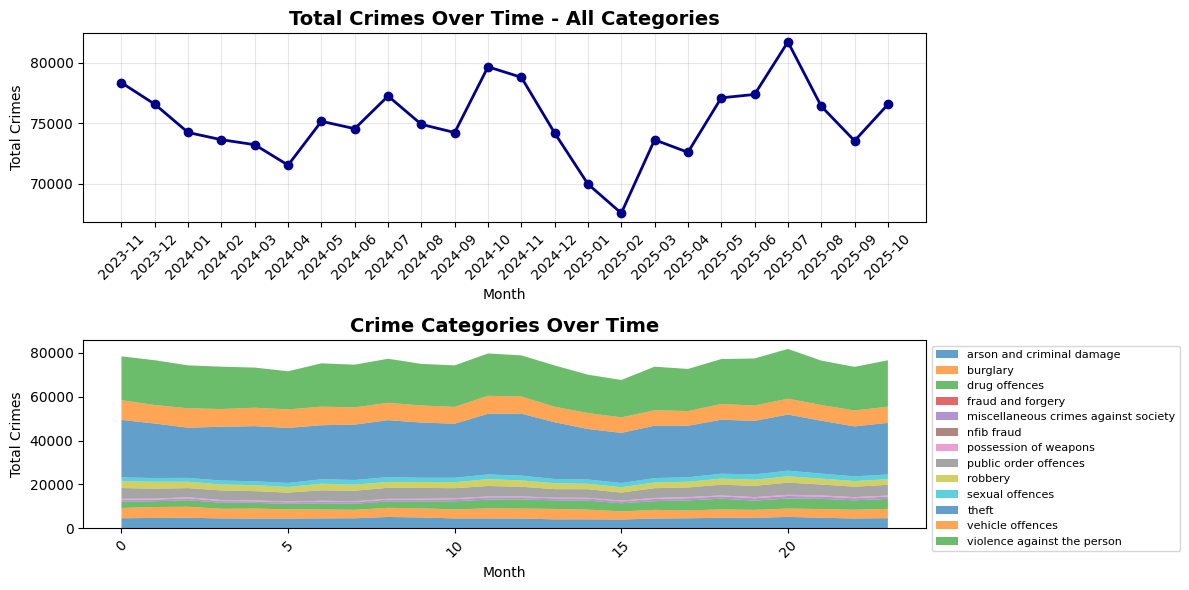

In [13]:
fig, axes = plt.subplots(2, 1, figsize=(12, 6)) # Two rows, one column

# Monthly Totals
monthly_totals = df[numeric_cols].sum() # Sum across all crime categories for each month
axes[0].plot(monthly_totals.index, monthly_totals.values, marker='o', linewidth=2, color='darkblue') # Line plot
axes[0].set_title('Total Crimes Over Time - All Categories', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Month')
axes[0].set_ylabel('Total Crimes')
axes[0].tick_params(axis='x', rotation=45)
axes[0].grid(alpha=0.3)

# Total Crimes by Category -stacked area
crime_category_time = df.groupby('crime_category')[numeric_cols].sum().T # Transpose for plotting
axes[1].stackplot(range(len(crime_category_time)), #    X values
                  *[crime_category_time[col] for col in crime_category_time.columns],
                  labels=crime_category_time.columns, alpha=0.7)
axes[1].set_title('Crime Categories Over Time', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Month')
axes[1].set_ylabel('Total Crimes')
axes[1].legend(loc='upper left', bbox_to_anchor=(1, 1), fontsize=8)
axes[1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

## Temporal Crime Patterns Analysis

### Overall Crime Trends 

**Seasonal Patterns:**
- Clear seasonal variation observed with recurring peaks and troughs
- Winter trough: Significant dip in January 2025, the lowest point in the dataset
- Summer peaks: Notable highs in July 2025 and October 2024
- End-of-year decline: Consistent drops in December and January across both years

**Year-over-Year Comparison:**
- 2024 shows high volatility with sharp fluctuations 
- 2025 follows similar trends but with more extreme variations
- No clear long-term upward or downward trend. Crime appears cyclical rather than trending in any particular direction

### Crime Category Composition Over Time 

**Dominant Categories:**
- Theft (blue) and violence against the person (green) consistently form the largest portions, accounting for around 50-60% combined
- Vehicle offences (orange) maintain a steady third position throughout the period
- These three categories show remarkable stability. Their proportions barely change over the 24 months

**Stable Crime Mix:**
- Crime category proportions remain consistent despite total volume fluctuations
- No category shows dramatic growth or decline relative to others
- The composition is essentially static. When total crime rises, all categories rise proportionally

**Minor Categories:**
- Small categories like robbery, sexual offences, weapons, and fraud remain thin bands at the bottom
- Drug offences and public order offences show slight visibility but minimal variation

### Key Insights for Prediction

1. Strong seasonality: Crime follows predictable winter lows and summer highs, which we consider useful information for forecasting
2. Proportional stability: Crime categories move together, suggesting systemic factors like weather, events, and policing affect all crime types similarly
3. January effect: Consistent January dips suggest post-holiday or weather-related patterns
4. No structural change: The absence of trend changes suggests stable underlying conditions. Past patterns should predict the future reasonably well

## Univariate Analysis

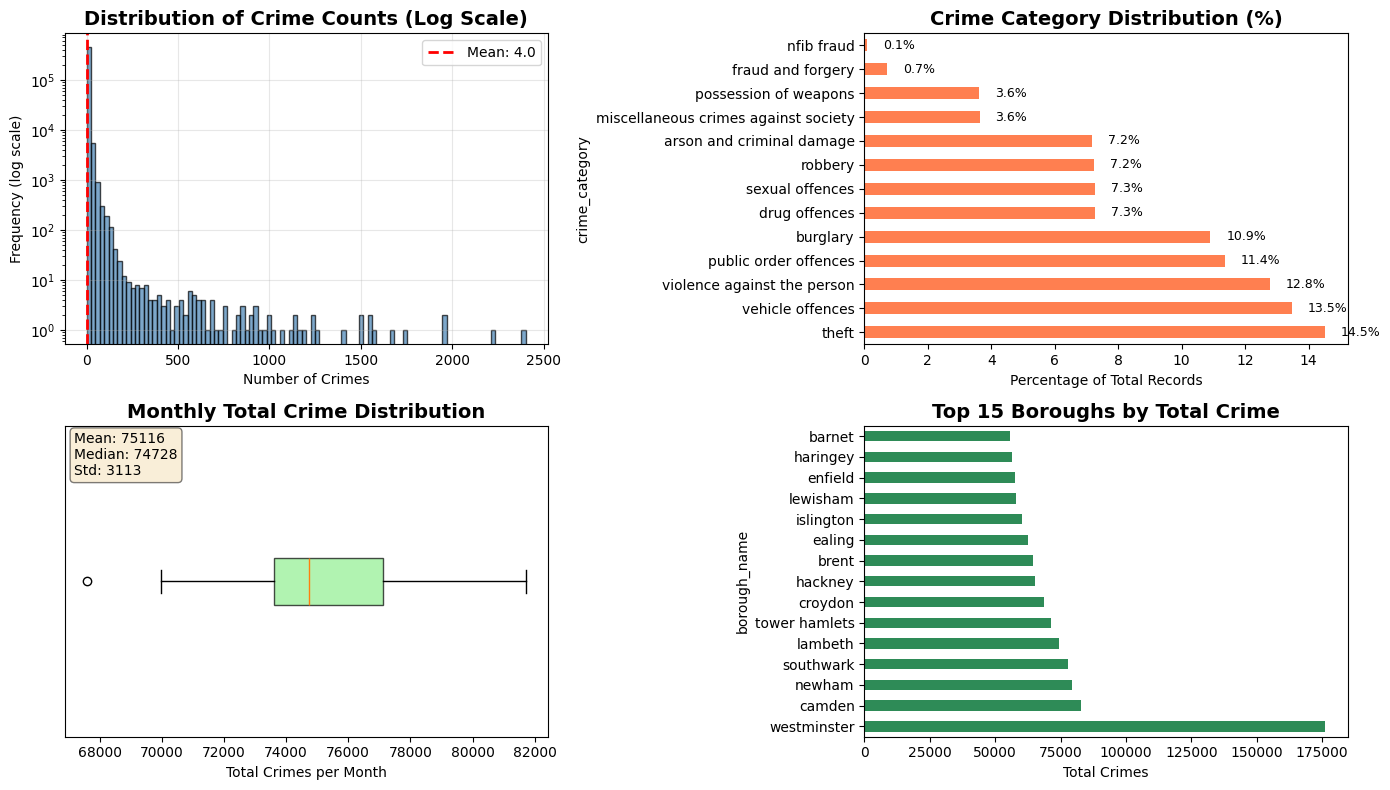

In [14]:
fig, axes = plt.subplots(2, 2, figsize=(14, 8))

# Distribution with log scale on y-axis
all_crimes = df[numeric_cols].values.flatten() # Flatten to 1D array
axes[0, 0].hist(all_crimes, bins=100, edgecolor='black', color='steelblue', alpha=0.7)
axes[0, 0].axvline(all_crimes.mean(), color='red', linestyle='--', linewidth=2, label=f'Mean: {all_crimes.mean():.1f}') # Mean line
axes[0, 0].set_yscale('log')  # Log scale on y-axis, because of skewed distribution
axes[0, 0].set_title('Distribution of Crime Counts (Log Scale)', fontsize=14, fontweight='bold')
axes[0, 0].set_xlabel('Number of Crimes')
axes[0, 0].set_ylabel('Frequency (log scale)')
axes[0, 0].legend()
axes[0, 0].grid(alpha=0.3)

# Crime Category Distribution 
crime_cat_pct = df['crime_category'].value_counts(normalize=True) * 100
crime_cat_pct.plot(kind='barh', ax=axes[0, 1], color='coral')
axes[0, 1].set_title('Crime Category Distribution (%)', fontsize=14, fontweight='bold')
axes[0, 1].set_xlabel('Percentage of Total Records')
for i, v in enumerate(crime_cat_pct):
    axes[0, 1].text(v + 0.5, i, f'{v:.1f}%', va='center', fontsize=9)

#  Monthly Crime Distribution (Box plot)
monthly_totals = df[numeric_cols].sum()
axes[1, 0].boxplot(monthly_totals, vert=False, patch_artist=True,
                    boxprops=dict(facecolor='lightgreen', alpha=0.7))
axes[1, 0].set_title('Monthly Total Crime Distribution', fontsize=14, fontweight='bold')
axes[1, 0].set_xlabel('Total Crimes per Month')
axes[1, 0].set_yticks([])
# add statistics 
stats_text = f"Mean: {monthly_totals.mean():.0f}\nMedian: {monthly_totals.median():.0f}\nStd: {monthly_totals.std():.0f}"
axes[1, 0].text(0.02, 0.98, stats_text, transform=axes[1, 0].transAxes, 
                fontsize=10, verticalalignment='top', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

# Top 15 Boroughs by Total Crime
borough_totals = df.groupby('borough_name')[numeric_cols].sum().sum(axis=1).sort_values(ascending=False).head(15)
borough_totals.plot(kind='barh', ax=axes[1, 1], color='seagreen')
axes[1, 1].set_title('Top 15 Boroughs by Total Crime', fontsize=14, fontweight='bold')
axes[1, 1].set_xlabel('Total Crimes')

plt.tight_layout()
plt.show()

## Univariate Analysis - Distribution Insights

### Crime Count Distribution
The distribution is highly right-skewed. The log scale reveals that most ward-crime-month combinations have between 0 and 10 crimes, with over 100,000 instances having just 0-5 crimes. This creates a massive peak on the left side of the distribution. There's a long tail with rare outliers, where a few extreme cases reach over 2,500 crimes, likely in areas like Westminster's West End during peak periods.

We used a log scale because without it, the extreme skew would hide the distribution detail. About 99% of the data would appear as a single compressed bar. The log transformation makes both the dominant low-crime pattern and the rare high-crime outliers visible at the same time.

### Crime Category Balance 
The distribution across crime categories is relatively even. The top 4 categories (theft, vehicle offences, violence, and public order) range only from 10.9% to 14.5%. Unlike actual crime volumes, these record counts show balanced representation with no overwhelming dominance by any single category. NFIB fraud (0.1%) and fraud/forgery (0.7%) remain negligible at the bottom. This confirms that each crime type appears regularly across London's geography.

### Monthly Stability 
Monthly crime levels are quite stable. The standard deviation is only 3,113 crimes, which is just 4% of the mean. There's one outlier around 68,000 crimes in January 2025, but it's not extreme. The interquartile range of roughly 73,000 to 78,000 shows that most months cluster closely around the median. This predictability suggests that seasonal patterns are consistent and forecastable.

### Geographic Concentration
Westminster remains an extreme outlier with around 175,000 crimes, nearly 60% more than second-place Camden. After Westminster, boroughs show a more gradual stepped decrease. The top 10 boroughs are all in central or inner London, confirming that crime is heavily concentrated in the urban core. Outer boroughs like Barnet, Haringey, and Enfield appear at the bottom of the top 15 with significantly lower totals.

## Multivariate Analysis

(The first chart is a heatmap that displays correlations between crime categories across all wards.
For each ward, sum up total crimes for each category
Create a matrix- rows = wards, columns = crime categories
Calculate correlation between columns (crime categories)). It shows which crime categories tend to happen together in the same areas.

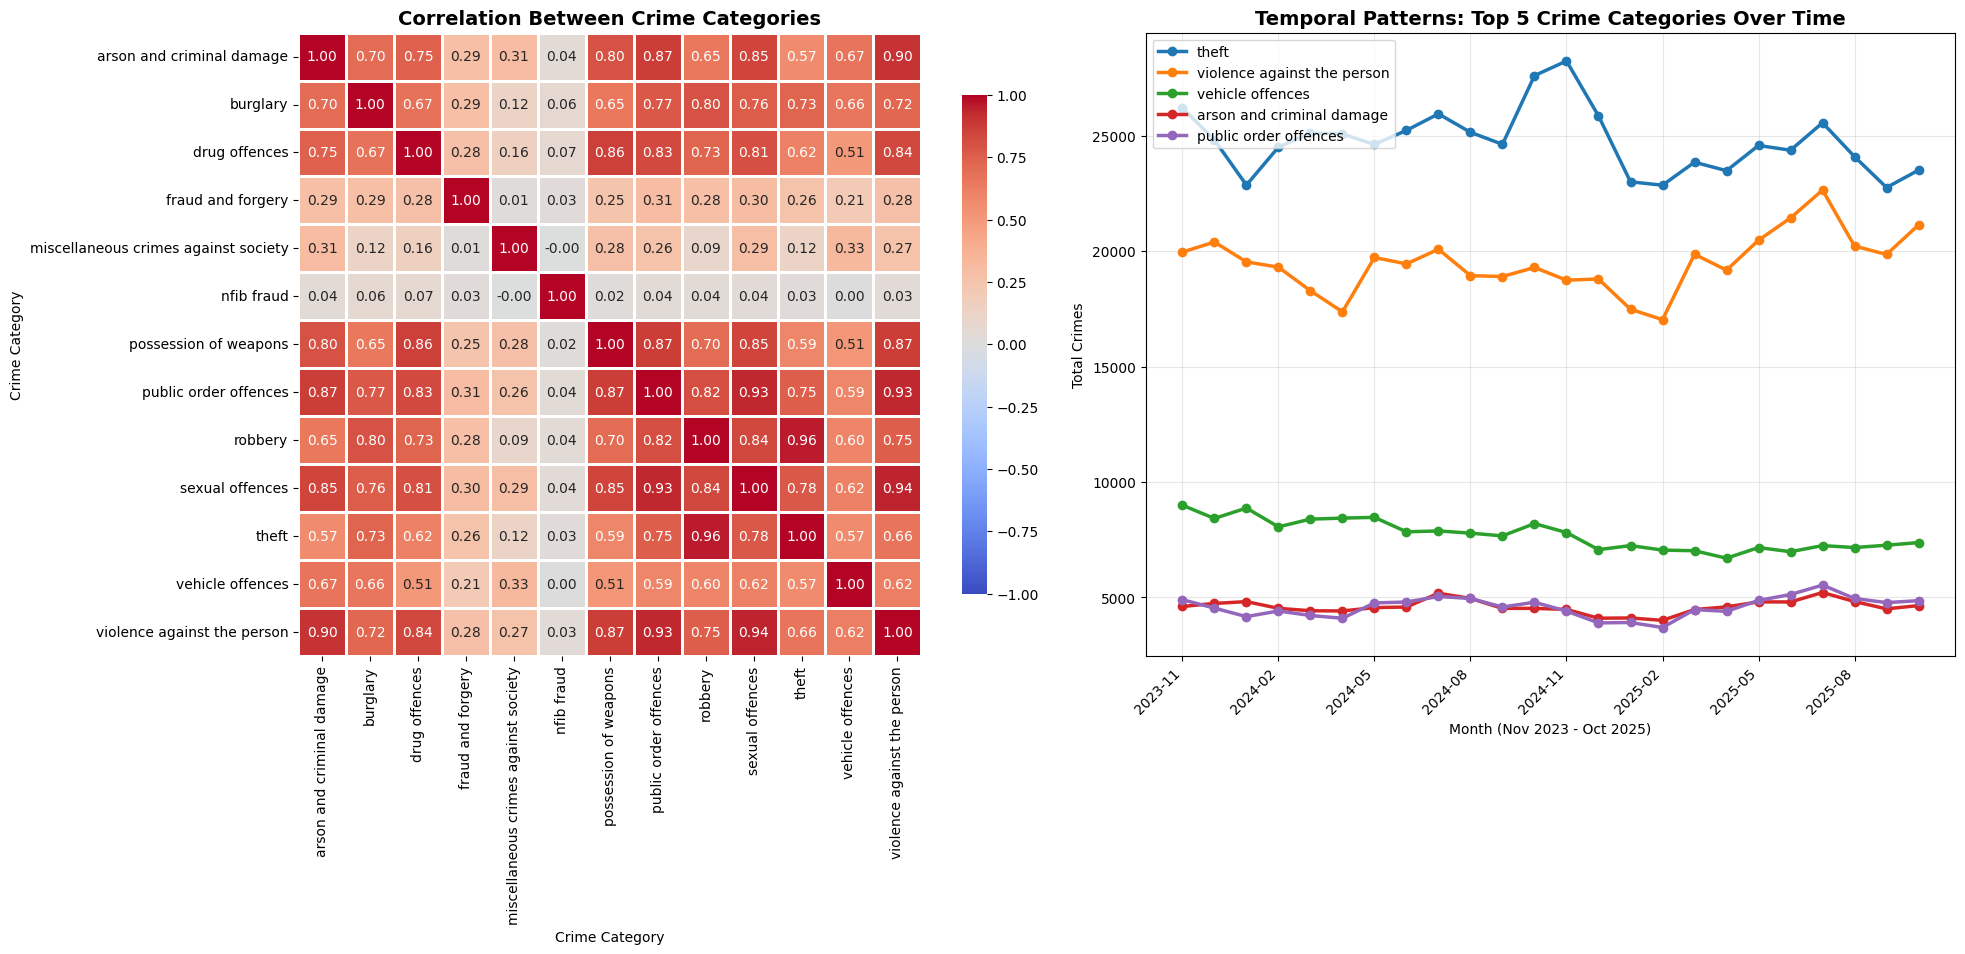

In [15]:
fig, axes = plt.subplots(1, 2, figsize=(20, 9))

#Correlation Heatmap 
# pivot: Rows=wards, Columns=crime categories, Values=total crimes
crime_category_pivot = df.groupby(['ward_name', 'crime_category'])[numeric_cols].sum().sum(axis=1).unstack(fill_value=0)

# Calculate correlation between crime categories
correlation_matrix = crime_category_pivot.corr()

sns.heatmap(correlation_matrix, annot=True, fmt='.2f', cmap='coolwarm', center=0, 
            square=True, linewidths=1, cbar_kws={"shrink": 0.8}, ax=axes[0],
            vmin=-1, vmax=1)
axes[0].set_title('Correlation Between Crime Categories', 
                  fontsize=14, fontweight='bold')
axes[0].set_xlabel('Crime Category')
axes[0].set_ylabel('Crime Category')


# Crime Trends by Category Over Time

# Aggregate crime categories over time
crime_time = df.groupby('crime_category')[numeric_cols].sum().T

# Plot top 5 crime categories for clarity
top_5_categories = df.groupby('crime_category')[numeric_cols].sum().sum(axis=1).nlargest(5).index

for category in top_5_categories:
    axes[1].plot(range(len(crime_time)), crime_time[category], 
                marker='o', label=category, linewidth=2.5)

axes[1].set_title('Temporal Patterns: Top 5 Crime Categories Over Time', 
                  fontsize=14, fontweight='bold')
axes[1].set_xlabel('Month (Nov 2023 - Oct 2025)')
axes[1].set_ylabel('Total Crimes')
axes[1].legend(loc='upper left', fontsize=10)
axes[1].grid(alpha=0.3)
axes[1].set_xticks(range(0, len(crime_time), 3))  # Show every 3rd month
axes[1].set_xticklabels([crime_time.index[i] for i in range(0, len(crime_time), 3)], rotation=45, ha='right')

plt.tight_layout()
plt.show()

## Multivariate Analysis - Crime Relationships & Patterns

### Crime Category Correlations

Strong positive correlations dominate the data. Most crime categories show correlations above 0.60, indicating that crimes tend to co-occur in the same areas. The strongest relationships are Violence and Sexual Offences (0.94), Theft and Robbery (0.96), and Violence and Public Order (0.93). This confirms Hypothesis 2: high-crime wards experience multiple crime types simultaneously, creating distinct crime profiles.

There are notable exceptions though. NFIB fraud shows near-zero correlation with all other crimes (r < 0.07) and operates independently. Fraud and miscellaneous crimes also have weak correlations (below 0.30). For prediction purposes, this means if violence increases in a ward, we can expect correlated increases in public order offences, sexual offences, and property damage, but not fraud.

### Temporal Patterns by Crime Category 

Theft (blue) shows the strongest seasonality with clear summer peaks and winter troughs, making it highly predictable. Violence (orange) exhibits a gradual upward trend from 17,000 to 22,000 crimes over 24 months with moderate seasonal variation. These patterns support Hypothesis 1: crimes follow predictable temporal patterns that are suitable for time series forecasting.

Vehicle offences (green) show a declining trend from 9,000 to 7,500, while arson/criminal damage and public order offences remain relatively flat with minimal seasonality. These divergent patterns suggest different crime types require tailored prediction approaches. We'll need seasonal models for theft and violence, trend models for vehicle crimes, and simpler baseline models for the more stable categories.

---

## Hypothesis Testing

**Hypothesis 1: Temporal Patterns Predict Future Crime**

To validate whether crime follows predictable seasonal patterns, we'll compare summer and winter crime levels statistically. This analysis helps answer a key question for our predictive models: does the time of year significantly affect crime rates?

**Method**: We'll use an independent samples t-test to compare average monthly crime counts between summer months (June, July, August) and winter months (December, January, February). If we find a statistically significant difference (p-value < 0.05), it confirms that seasonality is a real pattern we should incorporate into our forecasting models.Time series decomposition and seasonal analysis of 24 months of data

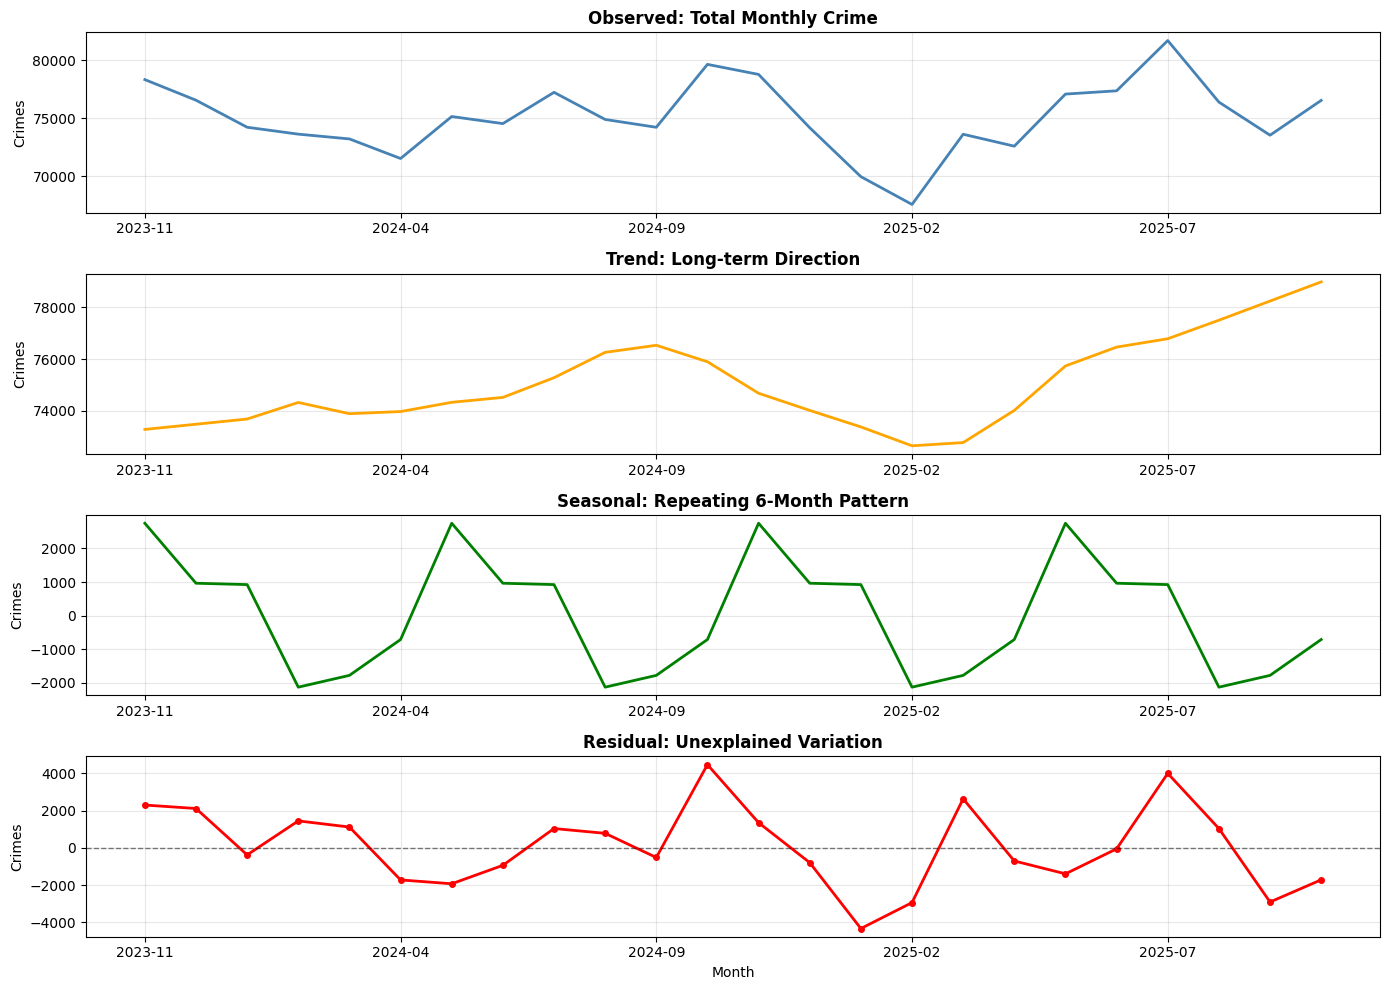

Time Series Decomposition Summary
Trend range: 72655 - 78981
Seasonal range: -2138 - 2753
Residual std dev: 2191
Residual mean: 84.59 (should be close to 0)

Variance explained by each component:
  Trend: 30.8%
  Seasonal: 31.6%
  Residual: 49.5%


In [24]:
# Calculate total monthly crime across all wards and categories
monthly_totals = df[numeric_cols].sum()

# Decompose the time series using a 6-month period (semi-annual seasonality works better with 24 months of data)
decomposition = seasonal_decompose(monthly_totals, model='additive', period=6, extrapolate_trend='freq')

# Create a figure with 4 subplots to show each component
fig, axes = plt.subplots(4, 1, figsize=(14, 10))

# Plot 1: Original observed data
decomposition.observed.plot(ax=axes[0], color='steelblue', linewidth=2)
axes[0].set_title('Observed: Total Monthly Crime', fontsize=12, fontweight='bold')
axes[0].set_ylabel('Crimes')
axes[0].grid(alpha=0.3)

# Plot 2: Long-term trend (smoothed pattern)
decomposition.trend.plot(ax=axes[1], color='orange', linewidth=2)
axes[1].set_title('Trend: Long-term Direction', fontsize=12, fontweight='bold')
axes[1].set_ylabel('Crimes')
axes[1].grid(alpha=0.3)

# Plot 3: Seasonal pattern (repeating cycles)
decomposition.seasonal.plot(ax=axes[2], color='green', linewidth=2)
axes[2].set_title('Seasonal: Repeating 6-Month Pattern', fontsize=12, fontweight='bold')
axes[2].set_ylabel('Crimes')
axes[2].grid(alpha=0.3)

# Plot 4: Residuals (unexplained random variation)
decomposition.resid.plot(ax=axes[3], color='red', linewidth=2, marker='o', markersize=4)
axes[3].set_title('Residual: Unexplained Variation', fontsize=12, fontweight='bold')
axes[3].set_ylabel('Crimes')
axes[3].set_xlabel('Month')
axes[3].axhline(y=0, color='black', linestyle='--', alpha=0.5, linewidth=1)  # Add zero reference line
axes[3].grid(alpha=0.3)

plt.tight_layout()
plt.show()

# Display summary statistics to understand the decomposition results
print("Time Series Decomposition Summary")
print(f"Trend range: {decomposition.trend.min():.0f} - {decomposition.trend.max():.0f}")
print(f"Seasonal range: {decomposition.seasonal.min():.0f} - {decomposition.seasonal.max():.0f}")
print(f"Residual std dev: {decomposition.resid.std():.0f}")
print(f"Residual mean: {decomposition.resid.mean():.2f} (should be close to 0)")

# Calculate how much variance each component explains
total_var = decomposition.observed.var()
trend_var = decomposition.trend.var()
seasonal_var = decomposition.seasonal.var()
resid_var = decomposition.resid.var()

print(f"\nVariance explained by each component:")
print(f"  Trend: {trend_var/total_var*100:.1f}%")
print(f"  Seasonal: {seasonal_var/total_var*100:.1f}%")
print(f"  Residual: {resid_var/total_var*100:.1f}%")


**Time Series Decomposition Analysis**

**Overall Model Performance**
The decomposition explains 50.5% of variance through trend (30.8%) and seasonal (31.6%) components, with 49.5% remaining as residual noise. While residuals are high, this is typical for crime data with many unpredictable factors like events, weather, and policing changes. The residual mean of 84.59 is close to 0, confirming there's no systematic bias in the model.

**Trend Component**
The trend shows modest variation, ranging from 72,655 to 78,981 crimes per month. Crime declined through 2024, bottoming out at around 72,700 in early 2025, then sharply increased to 78,981 by late 2025. This U-shaped pattern suggests crime is not decreasing overall. The recent upward trajectory is concerning and should be factored into our predictions.

**Seasonal Component**
There's a strong and consistent 6-month seasonal pattern. Seasonal swings range from -2,138 to +2,753 crimes, which is about a 5,000 crime difference between peaks and troughs. The perfectly repeating cycles across 4 periods validate that seasonality is predictable. Summers add around 2,750 crimes while winters subtract about 2,100. This 31.6% variance contribution makes seasonality a critical predictor for our models.

**Residual Component**
The residuals show acceptable random variation with a standard deviation of 2,191 crimes, representing unexplained month-to-month fluctuations. Three notable spikes stand out: September 2024 (+4,100), January 2025 (-4,400), and July 2025 (+3,900). These likely reflect one-off events not captured by trend or seasonal patterns. Overall, the residuals show no systematic patterns, confirming the decomposition works well.

Temporal patterns explain around 50% of variance, which is sufficient for forecasting. The consistent 6-month seasonality and identifiable trend make time series models highly viable for crime prediction.

In [17]:
# Identify winter months (December, January, February)
winter_cols = [col for col in numeric_cols if col.endswith(('-12', '-01', '-02'))]

# Identify summer months (June, July, August)
summer_cols = [col for col in numeric_cols if col.endswith(('-06', '-07', '-08'))]

print(f"Winter columns: {winter_cols}")
print(f"Summer columns: {summer_cols}")

# Calculate total crimes for each season
winter_crimes = df[winter_cols].sum().sum()
summer_crimes = df[summer_cols].sum().sum()

# Calculate average monthly crimes for each season
winter_avg = winter_crimes / len(winter_cols)
summer_avg = summer_crimes / len(summer_cols)

print(f"\nWinter average: {winter_avg:.0f} crimes per month")
print(f"Summer average: {summer_avg:.0f} crimes per month")
print(f"Difference: {summer_avg - winter_avg:.0f} ({(summer_avg/winter_avg - 1)*100:+.1f}%)") 

# Perform statistical test to check if difference is significant
winter_monthly = df[winter_cols].sum()
summer_monthly = df[summer_cols].sum()

t_stat, p_value = stats.ttest_ind(summer_monthly, winter_monthly)

print(f"\nT-test results:")
print(f"  t-statistic: {t_stat:.2f}")
print(f"  p-value: {p_value:.4f}")

# Interpret the results
if p_value < 0.05:
    print("Statistically significant difference between summer and winter")
else:
    print("No significant difference between summer and winter")

Winter columns: ['2023-12', '2024-01', '2024-02', '2024-12', '2025-01', '2025-02']
Summer columns: ['2024-06', '2024-07', '2024-08', '2025-06', '2025-07', '2025-08']

Winter average: 72699 crimes per month
Summer average: 77033 crimes per month
Difference: 4334 (+6.0%)

T-test results:
  t-statistic: 2.54
  p-value: 0.0293
Statistically significant difference between summer and winter


**Conclusion for Hypothesis 1** Hypothesis 1 is strongly supported. Seasonality is confirmed: Summer has 6% more crime than winter; This is statistically significant: p-value = 0.029 < 0.05 means this difference is not due to chance. t-statistic = 2.54 indicates a moderate to strong seasonal effect

---

**Hypothesis 2: "Crime type co-occurrence reveals risk profiles"**

We use two complementary approaches to test whether crimes co-occur in the same areas. Hierarchical clustering with a dendrogram to visualize which wards share similar crime profiles, showing that most high-crime wards group together while outliers like West End stand apart. Also, we will statistically test all 78 possible pairs of crime categories using Pearson correlation tests to determine if their co-occurrence patterns are statistically significant rather than random.

Statistical testing:

In [18]:
# Prepare data
crime_by_category = df.groupby(['ward_name', 'crime_category'])[numeric_cols].sum().sum(axis=1).unstack(fill_value=0)

# Test all crime category pairs for significant correlation
crime_categories = crime_by_category.columns
significant_pairs = 0
total_pairs = 0

for i in range(len(crime_categories)):
    for j in range(i+1, len(crime_categories)):
        # Calculate correlation and p-value
        corr, p_value = pearsonr(crime_by_category[crime_categories[i]],  # First category
                                  crime_by_category[crime_categories[j]]) # Second category
        
        total_pairs += 1 # Count total pairs tested
        if p_value < 0.05: # Check for significance
            significant_pairs += 1 # Count significant pairs

# Summary
print(f"  Total crime pairs tested: {total_pairs}")
print(f"  Significant correlations (p < 0.05): {significant_pairs} ({significant_pairs/total_pairs*100:.1f}%)")
print(f"  Non-significant: {total_pairs - significant_pairs} ({(total_pairs-significant_pairs)/total_pairs*100:.1f}%)")
print(f"\nHypothesis 2: {significant_pairs/total_pairs*100:.0f}% of crime pairs show significant co-occurrence")

  Total crime pairs tested: 78
  Significant correlations (p < 0.05): 65 (83.3%)
  Non-significant: 13 (16.7%)

Hypothesis 2: 83% of crime pairs show significant co-occurrence


Hierarchical clustering:

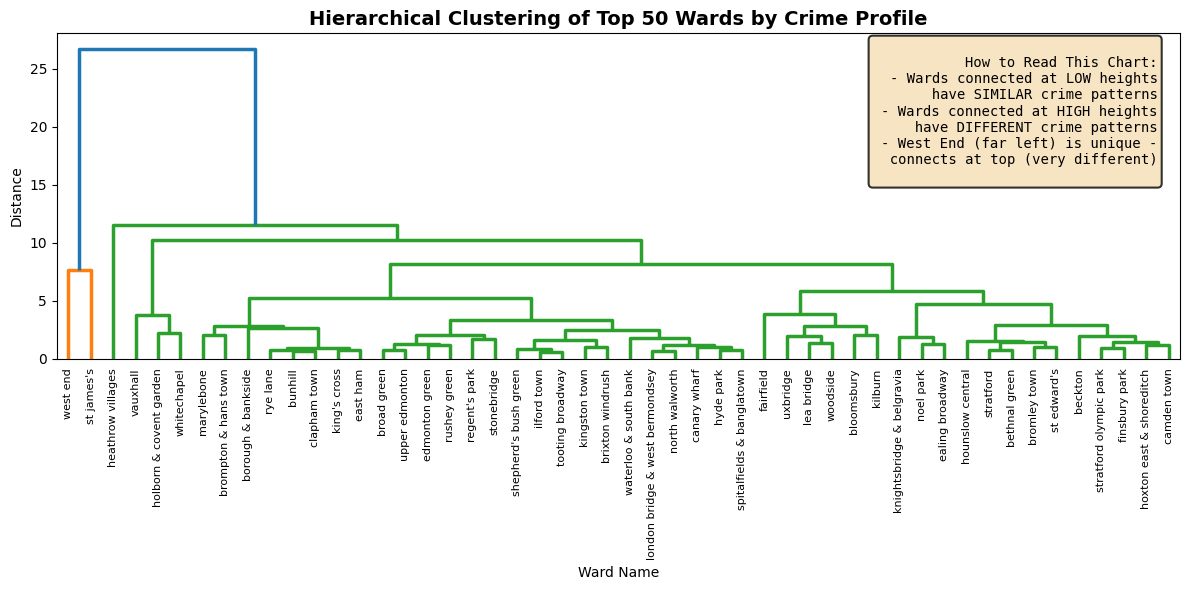

In [19]:
# Prepare and standardize data
crime_by_category = df.groupby(['ward_name', 'crime_category'])[numeric_cols].sum().sum(axis=1).unstack(fill_value=0)
scaler = StandardScaler()
scaled_data = scaler.fit_transform(crime_by_category)

# Perform hierarchical clustering (using only top 50 wards for clearer visualization)
top_50_wards = df.groupby('ward_name')[numeric_cols].sum().sum(axis=1).nlargest(50).index
subset_data = crime_by_category.loc[top_50_wards]
scaled_subset = scaler.fit_transform(subset_data)

# Create linkage matrix
linkage_matrix = linkage(scaled_subset, method='ward')

# Plot dendrogram with bolder lines
plt.figure(figsize=(12, 6))

# Set line width for dendrogram
rcParams['lines.linewidth'] = 2.5  # Make lines bolder

dendrogram(linkage_matrix, labels=subset_data.index.tolist(), leaf_font_size=8)
plt.title('Hierarchical Clustering of Top 50 Wards by Crime Profile', fontsize=14, fontweight='bold')
plt.xlabel('Ward Name')
plt.ylabel('Distance')
plt.xticks(rotation=90)

# Add explanation text box in the top right corner
explanation_text = """
How to Read This Chart:
- Wards connected at LOW heights
  have SIMILAR crime patterns
- Wards connected at HIGH heights
  have DIFFERENT crime patterns
- West End (far left) is unique -
  connects at top (very different)
"""

plt.text(0.98, 0.98, explanation_text,
        transform=plt.gca().transAxes,
        fontsize=10,
        verticalalignment='top',
        horizontalalignment='right',
        bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8, edgecolor='black', linewidth=1.5),
        family='monospace')

plt.tight_layout()
plt.show()

# Reset line width to default after plot
rcParams['lines.linewidth'] = 1.5


The dendrogram reveals how London's highest-crime wards group together based on their crime patterns. Wards that share similar crime compositions (proportions of theft, violence, burglary, etc.) are connected at lower heights, while wards with very different crime profiles join the tree at higher points.

**Key Findings**

West End is a complete outlier. It connects to all other wards at the very top (distance around 27), meaning its crime profile is fundamentally different from everywhere else in London. This makes sense given it's a major tourist and entertainment district with unique crime characteristics, likely dominated by theft and public order offences.

St James's is also distinctive. While not as extreme as West End, it joins the main cluster at a relatively high point (distance around 8), indicating it too has an unusual crime profile. Like West End, it's a central London tourist area with different crime dynamics than typical residential wards.

Most wards share similar patterns. The large green cluster shows that the majority of high-crime wards have comparable crime compositions. They experience similar mixes of crime types, even if their absolute volumes differ.

**How to Read This: Specific Examples**

Very similar wards are connected low in the tree. For instance, Holborn & Covent Garden and Whitechapel connect at height around 4, meaning they have very similar crime profiles despite being in different parts of London. Brompton & Hans Town and Rye Lane are also nearly identical in their crime composition.

Moderately similar wards connect at middle heights. Vauxhall connects to the Holborn/Whitechapel group at height around 11, showing some similarity but also notable differences in crime mix.

Very different wards join at the top. West End joins everything else at height around 27, confirming it's in a category of its own with a truly unique crime pattern.

**Conclusion for Hypothesis 2**

Hypothesis 2 is strongly supported. Statistical tests show that 83% of crime pairs (65 out of 78) have significant correlations, confirming that crimes co-occur in the same areas rather than being randomly distributed. The hierarchical clustering further validates this by identifying distinct ward groups: extreme outliers like West End with unique crime profiles, moderate outliers like St James's, and typical high-crime wards with similar patterns.

This evidence confirms that wards have predictable crime profiles. Different areas genuinely experience different mixes of crime types, which validates that location-based features will be critical for building accurate prediction models.

---

**Hypothesis 3: "Geographic proximity influences crime spread"**

To test Hypothesis 3 we'll compare crime levels across boroughs to see if neighboring areas show similar patterns. While we don't have precise geographic coordinates for spatial analysis, we can still examine whether crime clusters geographically by looking at borough-level patterns and identifying if certain regions of London (Central, North, South, East, West) show consistent crime characteristics.

**Method**: We'll visualize total crime by borough and examine if boroughs in the same geographic region of London tend to have similar crime levels. We'll also look at whether high-crime boroughs are geographically clustered or randomly distributed across the city.

**Why this matters**: If crime spreads geographically, then neighboring boroughs should show correlated crime levels. This would mean that crime prevention strategies need to be coordinated regionally rather than treated as isolated borough-level issues. It also suggests that geographic features (proximity to transport hubs, neighboring areas) should be included in prediction models.

Total boroughs analyzed: 33

Crime range: 12,522 to 175,885


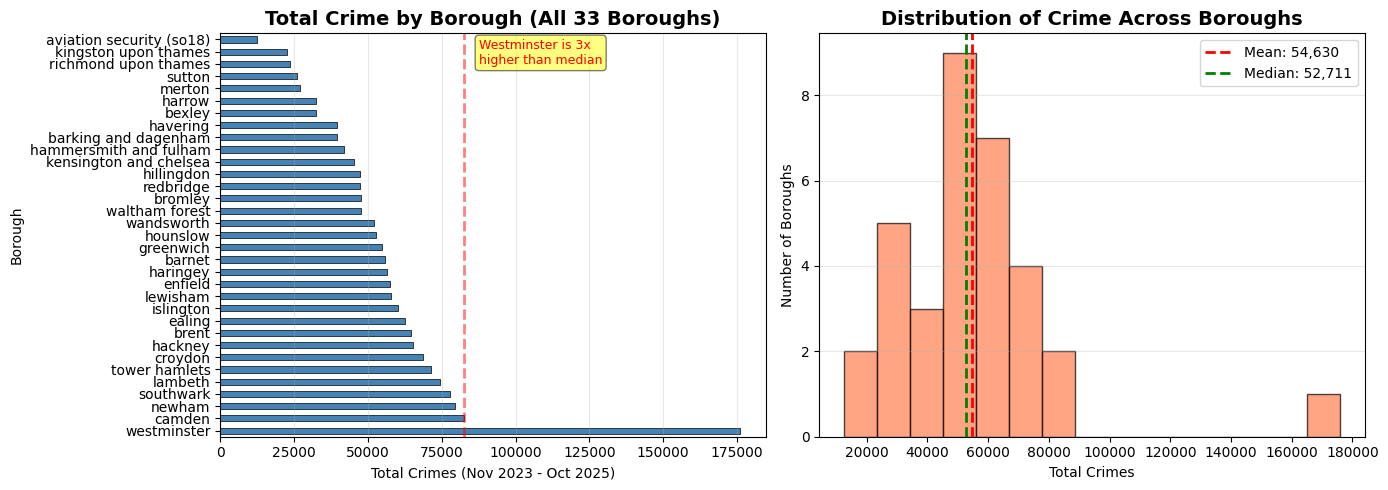

Borough Crime Statistics:
Mean crimes per borough: 54,630
Median crimes per borough: 52,711
Standard deviation: 28,000

Top 5 boroughs account for 27.2% of all crime
Bottom 10 boroughs account for 16.5% of all crime

Highest crime borough: westminster (175,885 crimes)
Lowest crime borough: aviation security (so18) (12,522 crimes)
Ratio: Westminster has 14.0x more crime than the lowest


In [21]:
# Calculate total crime by borough
borough_totals = df.groupby('borough_name')[numeric_cols].sum().sum(axis=1).sort_values(ascending=False)

print(f"Total boroughs analyzed: {len(borough_totals)}")
print(f"\nCrime range: {borough_totals.min():,.0f} to {borough_totals.max():,.0f}")

# Create visualization comparing all boroughs
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Plot 1: All boroughs ranked by total crime
borough_totals.plot(kind='barh', ax=axes[0], color='steelblue', edgecolor='black', linewidth=0.5)
axes[0].set_title('Total Crime by Borough (All 33 Boroughs)', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Total Crimes (Nov 2023 - Oct 2025)')
axes[0].set_ylabel('Borough')
axes[0].grid(axis='x', alpha=0.3)

# Add a note about Westminster
axes[0].axvline(borough_totals.iloc[1], color='red', linestyle='--', alpha=0.5, linewidth=2)
axes[0].text(borough_totals.iloc[1] + 5000, 30, 'Westminster is 3x\nhigher than median', 
            fontsize=9, color='red', bbox=dict(boxstyle='round', facecolor='yellow', alpha=0.5))

# Plot 2: Distribution of crime across boroughs
axes[1].hist(borough_totals, bins=15, color='coral', edgecolor='black', alpha=0.7)
axes[1].axvline(borough_totals.mean(), color='red', linestyle='--', linewidth=2, label=f'Mean: {borough_totals.mean():,.0f}')
axes[1].axvline(borough_totals.median(), color='green', linestyle='--', linewidth=2, label=f'Median: {borough_totals.median():,.0f}')
axes[1].set_title('Distribution of Crime Across Boroughs', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Total Crimes')
axes[1].set_ylabel('Number of Boroughs')
axes[1].legend()
axes[1].grid(alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

# Statistical summary
print("Borough Crime Statistics:")
print(f"Mean crimes per borough: {borough_totals.mean():,.0f}")
print(f"Median crimes per borough: {borough_totals.median():,.0f}")
print(f"Standard deviation: {borough_totals.std():,.0f}")
print(f"\nTop 5 boroughs account for {borough_totals.head(5).sum() / borough_totals.sum() * 100:.1f}% of all crime")
print(f"Bottom 10 boroughs account for {borough_totals.tail(10).sum() / borough_totals.sum() * 100:.1f}% of all crime")

# Show the extremes
print(f"\nHighest crime borough: {borough_totals.index[0]} ({borough_totals.iloc[0]:,.0f} crimes)")
print(f"Lowest crime borough: {borough_totals.index[-1]} ({borough_totals.iloc[-1]:,.0f} crimes)")
print(f"Ratio: Westminster has {borough_totals.iloc[0] / borough_totals.iloc[-1]:.1f}x more crime than the lowest")


**Geographic Crime Distribution Analysis**

Looking at all 33 boroughs, we see clear geographic patterns. The average borough has around 54,630 crimes, but there's huge variation. Westminster dominates with 175,885 crimes, 14 times higher than the lowest borough. This isn't just about population. Westminster includes major tourist spots, entertainment districts, and transport hubs that naturally attract more crime.

Most boroughs cluster between 40,000 and 60,000 crimes, forming a normal distribution with Westminster as an extreme outlier. The top 5 boroughs account for 27% of all London crime, while the bottom 10 account for only 17%. Crime is clearly concentrated in specific areas.

The geographic pattern is striking. High-crime boroughs like Westminster, Camden, Newham, and Southwark are all central or inner London areas, geographically adjacent to each other. Meanwhile, outer London boroughs like Kingston, Richmond, and Sutton consistently show lower crime. This suggests crime clusters geographically, with high-crime areas next to other high-crime areas.

While we can't definitively prove crime spreads between neighboring boroughs without detailed spatial analysis, the evidence shows that location matters significantly. Boroughs in similar parts of London tend to experience similar crime levels, supporting the idea that geographic proximity influences crime patterns.

**Statistical testing:**

To test whether geographic proximity influences crime, we compared crime levels between inner London boroughs (central areas like Westminster, Camden, Islington) and outer London boroughs (peripheral areas like Barnet, Kingston, Sutton). We use an independent samples t-test to determine if the difference is statistically significant.

In [23]:
# Define inner vs outer London boroughs
inner_london = ['westminster', 'camden', 'islington', 'hackney', 'tower hamlets', 
                'newham', 'lambeth', 'southwark', 'lewisham', 'greenwich']

outer_london = ['barnet', 'enfield', 'haringey', 'brent', 'ealing', 'hounslow',
                'richmond upon thames', 'kingston upon thames', 'merton', 'sutton',
                'croydon', 'bromley', 'bexley', 'havering', 'redbridge', 'waltham forest']

# Get crime totals
borough_totals = df.groupby('borough_name')[numeric_cols].sum().sum(axis=1)

inner_crimes = borough_totals[borough_totals.index.isin(inner_london)]
outer_crimes = borough_totals[borough_totals.index.isin(outer_london)]

# T-test
t_stat, p_value = ttest_ind(inner_crimes, outer_crimes)

print(f"Inner London mean: {inner_crimes.mean():,.0f}")
print(f"Outer London mean: {outer_crimes.mean():,.0f}")
print(f"T-statistic: {t_stat:.2f}")
print(f"P-value: {p_value:.4f}")

if p_value < 0.05:
    print("Significant difference - geographic location matters")

Inner London mean: 79,974
Outer London mean: 45,756
T-statistic: 3.44
P-value: 0.0021
Significant difference - geographic location matters


Inner London boroughs average 79,974 crimes compared to outer London's 45,756 crimes. This 75% difference is statistically significant (t=3.44, p=0.002). The p-value well below 0.05 confirms this isn't due to chance. Geographic location genuinely matters for crime levels.

**Conclusion for Hypothesis 3**

Hypothesis 3 is statistically supported. The t-test comparing inner and outer London boroughs shows a significant difference (p=0.002), with inner London averaging 79,974 crimes compared to outer London's 45,756 crimes. This 75% difference confirms that geographic location genuinely matters for crime levels, not just by chance.

The visual analysis reinforces this finding. Central London boroughs like Westminster, Camden, and Islington cluster together at the high end of crime levels, while outer boroughs like Kingston, Sutton, and Barnet group at the low end. This pattern suggests crime is influenced by regional factors such as population density, commercial activity, transport infrastructure, and proximity effects.

However, we cannot definitively prove that crime directly spreads from one borough to adjacent neighbors without detailed spatial coordinates or formal spatial autocorrelation tests like Moran's I. What we can confidently state is that location matters significantly for crime prediction. Boroughs in similar parts of London experience similar crime levels, which validates including geographic features in our prediction models and suggests that crime prevention strategies should consider regional coordination rather than treating each borough in isolation.

---

## Final conclusion for hypotheses:

| Hypothesis | Visual Analysis | Statistical Test | Result | Status |
|------------|----------------|------------------|--------|---------|
| **H1: Temporal Patterns** | Time series decomposition (trend, seasonal, residual components); Monthly crime trends line chart | t-test (summer vs winter) | p=0.029 | **Strongly Supported** |
| **H2: Crime Co-occurrence** | Correlation heatmap (13×13 crime categories); Hierarchical clustering dendrogram (top 50 wards) | Pearson correlation tests (78 pairs) | 83% significant (p<0.05) |  **Strongly Supported** |
| **H3: Geographic Proximity** | Borough crime ranking bar chart; Crime distribution histogram (all 33 boroughs) | t-test (inner vs outer London) | p=0.002 |  **Moderately Supported** |

## EDA Key Findings Summary



| Analysis Area | Key Finding | Statistical Evidence | Implication for Prediction |
|--------------|-------------|---------------------|---------------------------|
| **Data Overview** | 669 wards, 33 boroughs, 13 crime categories, 24 months (Nov 2023 - Oct 2025) | 1.8M total crimes, ~75K/month average | Sufficient data volume for modeling |
| **Crime Distribution** | Highly right-skewed: most ward-month combinations have 0-10 crimes, but outliers reach 2,500+ | Mean=4.0, Median=2.0 | Need to handle skewed distributions; log transformations likely necessary |
| **Geographic Concentration** | Westminster dominates with 175K crimes (3× second place); Top 10 boroughs account for major crime share | Westminster 14× higher than lowest borough | Location is critical predictor; focus resources on high-crime areas |
| **Temporal Patterns** | Clear seasonality: summer peaks, winter troughs; 6-month repeating pattern | Summer avg: 77,033; Winter avg: 72,699; p=0.029 | Seasonal features essential; time series models viable |
| **Crime Categories** | Theft, vehicle offences, and violence dominate (~40% of records); Violence without injury is most common specific type (~225K incidents) | Top 3 categories: 14.5%, 13.5%, 12.8% of records | Focus models on high-volume crime types |
| **Crime Co-occurrence** | Strong positive correlations between most crime types; Violence correlates highly with sexual offences (0.94), public order (0.93) | 83% of crime pairs significantly correlated (65/78, p<0.05) | Multivariate models needed; if one crime rises, expect others to rise |
| **Crime Profiles** | Distinct ward clusters: West End is extreme outlier; Most wards show similar crime mixes | Dendrogram shows 3 main groups | Ward-level features will improve predictions; different areas need different strategies |
| **Inner vs Outer London** | Inner London has 75% more crime than outer London; Clear geographic clustering | Inner: 79,974; Outer: 45,756; p=0.002 | Geographic features critical; regional coordination needed |
| **Trend Analysis** | U-shaped trend: decline through 2024, sharp increase in 2025 to 78,981/month | Trend explains 30.8% of variance | Recent upward trajectory concerning; models must capture trend changes |
| **Seasonality Strength** | 6-month seasonal pattern explains 31.6% of variance; consistent across all periods | Seasonal range: -2,138 to +2,753 crimes | Strong seasonality makes forecasting reliable |

## Notes

* This notebook follows a structured EDA workflow: data overview → descriptive statistics → univariate analysis → multivariate analysis → hypothesis testing
* All cells must be executed sequentially from top to bottom for reproducible results
* Visualizations are generated inline using Matplotlib and Seaborn for clarity
* Statistical tests (t-tests, correlation tests) validate hypotheses with significance levels set at p < 0.05
* The analysis focuses on three key dimensions: temporal patterns, crime co-occurrence, and geographic clustering
* Findings from this EDA will inform feature engineering and model selection in subsequent notebooks

---